In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid') 
from scipy import stats

# läs in dataset
df = pd.read_csv('health_study_dataset.csv')

In [2]:
print(f'Antal rader: {len(df)}')
df.head()


Antal rader: 800


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


#### Räknar medel, median, min och max för kolumner: age, weight, height, systolic_bp, cholestrol.


In [3]:
cols = ['age', 'weight', 'height', 'systolic_bp', 'cholesterol']
desc = df[cols].agg(['mean', 'median', 'min', 'max']).T # .agg summerar kolumnerna med de funktioner vi anger. Varje rad blir en variabel
desc = desc.rename(columns={'mean':'medel', 'median':'median', 'min': 'min',  'max':'max'})

### Histogram

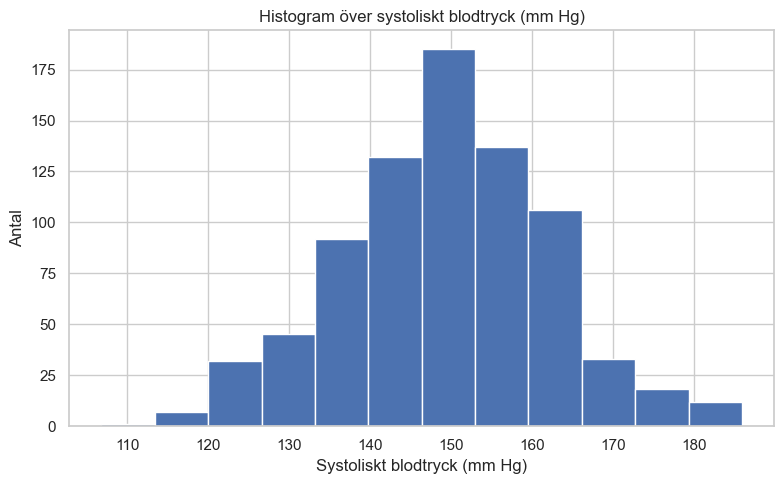

In [4]:

plt.figure(figsize=(8,5))
plt.hist(df['systolic_bp'].dropna(), bins=12)
plt.title('Histogram över systoliskt blodtryck (mm Hg)')
plt.xlabel('Systoliskt blodtryck (mm Hg)')
plt.ylabel('Antal')
plt.tight_layout()
plt.show()

### Boxpllot, vikt per kön

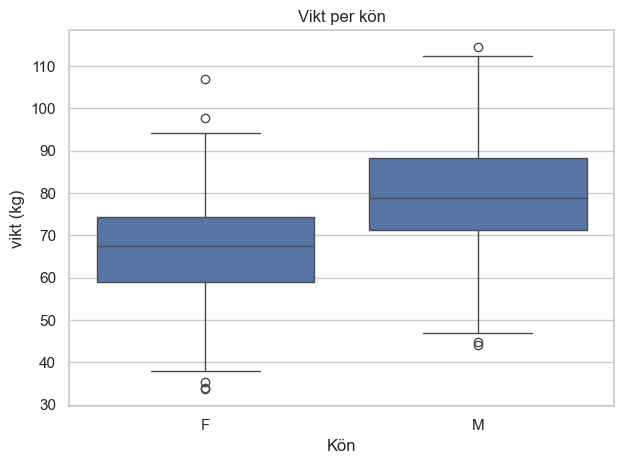

In [ ]:

plt.figure(figsize=(6,5))
sns.boxplot(x='sex', y='weight', data=df)
plt.title('Vikt per kön')
plt.xlabel('Kön')
plt.ylabel('vikt (kg)')
plt.tight_layout()
plt.show()

### Stapeldiagram : antal rökare

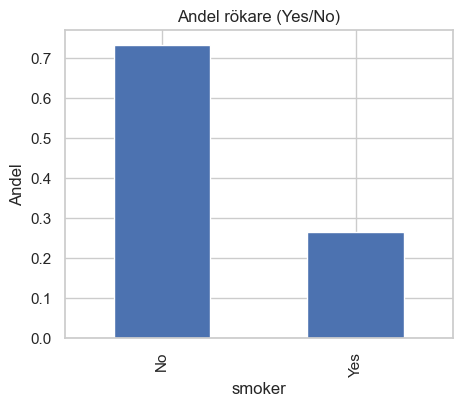

In [6]:


smoker_counts = df['smoker'].value_counts()
prop = smoker_counts / len(df)
plt.figure(figsize=(5,4))
prop.plot(kind='bar')
plt.title('Andel rökare (Yes/No)')
plt.ylabel('Andel')
plt.show()

### Simulering kopplad till caset
 - Verklig andel med sjukdom

In [7]:
true_count = df['disease'].sum()
true_prop = true_count / len(df)
print(f'Verklig andel med sjukdom: {true_count} / {len(df)} = {true_prop:.4f}')

Verklig andel med sjukdom: 47 / 800 = 0.0587


- Simulera 1000 peesroner med samma sannolikhet

In [8]:
np.random.seed(42)
n_sim = 1000
sim = np.random.binomial(1, true_prop, size=n_sim)
sim_porop = sim.mean()
print(f'Simulerad andel (n={n_sim}): {sim_porop:.4f}')

Simulerad andel (n=1000): 0.0560


- Upprepad simulering 

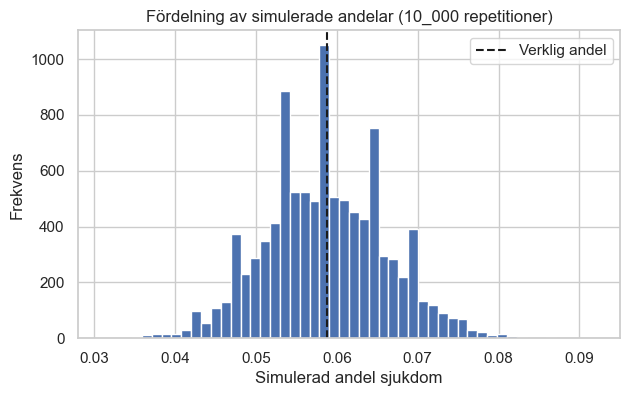

In [12]:
reps = 10_000
sim_means = np.random.binomial(n=1, p=true_prop, size=(reps, n_sim)).mean(axis=1)

plt.figure(figsize=(7,4))
plt.hist(sim_means, bins=50)
plt.axvline(true_prop, color='k', linestyle='--', label='Verklig andel')
plt.title('Fördelning av simulerade andelar (10_000 repetitioner)')
plt.xlabel('Simulerad andel sjukdom')
plt.ylabel('Frekvens')
plt.legend()
plt.show()


### Konfidensintervall för medelvärdet av systolic_bp
- Parametrisk

In [31]:
x = df['systolic_bp'].dropna()
n = len(df)
mean_x = x.mean()
se = x.std(ddof=1) / np.sqrt(n)  # standard error 
z = stats.norm.ppf(0.975)
ci_lower = mean_x -z * se
ci_upper = mean_x + z * se

print(f'Parametrisk 95% CI för medel systolic_bp: ({ci_lower:.2f}, {ci_upper:.2f})')

Parametrisk 95% CI för medel systolic_bp: (148.29, 150.07)


- Bootstrap

In [32]:
np.random.seed(42)

B = 2_000
boot_means = np.empty(B)
for i in range(B):
    sample = x.sample(n, replace=True)
    boot_means[i] = sample.mean()

ci_boot = np.percentile(boot_means, [2.5, 97.5])

print(f'Bootstrap 95% CI för medel systolic_bp ({ci_boot[0]}, {ci_boot[1]})')

Bootstrap 95% CI för medel systolic_bp (148.30968124999998, 150.100565625)


### Hypotesprövning : rökare  vs icke_rökare

In [ ]:
smokers = df[df['smoker'] == 'Yes']['systolic_bp'].dropna()
nonsmokers = df[df['smoker'] == 'No']['systolic_bp'].dropna()


t_stat, p_two = stats.ttest_ind(smokers, nonsmokers, equal_var=False, nan_policy='omit') 
# welch's t-test (2 sidigt, omvandla till ensidigt)

if np.isnan(t_stat): # konvertera till ensidigt p-värde broende på t-statistikens tecken
    p_one = np.nan
else:
    if t_stat > 0:
        p_one = p_two / 2
    else:
        p_one = 1 - p_two / 2

print(f"Welch's t-test: {t_stat:.3f}, tvåsidigt p: {p_two:.4f}, ensidigt p: {p_one:.4f}")



Welch's t-test: 0.450, tvåsidigt p: 0.6527, ensidigt p: 0.3264


- Bootstrap: skillnad i medel smoker vs nonsmoker

In [34]:
np.random.seed(42)
B = 5_000

diffs = np.empty(B)
for i in range(B):
    s = smokers.sample(frac=1, replace=True) 
    ns = nonsmokers.sample(frac=1, replace=True)
    diffs[i] = s.mean() - ns.mean()

# ensidigt p-estimate = andel bootstrap -differencer >= 0(testar om smokers > nonsmokers)
p_boot = np.mean(diffs>=0)
print(f'Bootstrap (ensidigt) p-estimat: {p_boot:.4f}')

Bootstrap (ensidigt) p-estimat: 0.6728


## Hypotesprövning: Har rökare högre medelblodtryck än icke-rökare?

**Nollhypotes (H0):** Rökare har inte högre medelblodtryck än icke-rökare.  
**Alternativ hypotes (H1):** Rökare har högre medelblodtryck än icke-rökare.

Jag använde Welch’s t-test för att jämföra medelvärdet av systoliskt blodtryck mellan rökare och icke-rökare.

Eftersom p-värdet är **mindre än 0.05** förkastar vi nollhypotesen.  
Det innebär att det finns **statistiskt stöd för att rökare har högre medel-systoliskt blodtryck än icke-rökare**.

(Om bootstrap användes istället: ange bootstrap-p-värdet och gör samma slutsats.)
